## GOAL - To study the imdb reviews dataset from hugging face. Specifically understand differences and similarities between positive and negative reviews with a labelled dataset. 
Reason for choosing this EDA for demo:
1.  IMDb Reviews is a well-known dataset, and many people are familiar with the IMDb platform. This familiarity can make it easier for anyone to relate to the data.
2. Understand how people use same words in different contexts because IMDB reviews are open to public and anyone can leave a review. A leblled dataset helps find words used in both positive and negative reviews. 
3. Answer questions like, do people write a lot more for negative reviews than positive, what are the most common adjectives used in a positive or negative review.
4. Sentiment analysis has practical relevance in various industries including marketing, customer feedback analysis and social media monitoring. 

Steps taken:
1. Analyze basic characterstics of dataset like number of reviews, class ratio, etc. including looking for missing values.
3. Splitting data into positive and negative reviews - essential to compare the two classes. 
4. Sentence and word length comparison - Understand whether people spend more time in typing longer reviews for negative or positive.
5. Word count histogram to find the most common words - tells us whether the most common words have any relevance.
6. Processing of reviews to remove irrelevant words, symbols, etc.
7. Bi-grams exploration - Identify commonly occurring pairs of words to understand everyday langugage pattern and get insights into how words are typically used together in positive and negative context.


In [1]:
import subprocess
subprocess.run(["python", "setup.py"])
# !pip install -r requirements.txt

CompletedProcess(args=['python', 'setup.py'], returncode=1)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import string
import seaborn as sns

from datasets import *
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
import nltk
from nltk import ngrams
# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\88mak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\88mak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\88mak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Using IMDB reviews for EDA demo. Ref: https://huggingface.co/datasets/imdb

Load dataset and print basic characterstics of dthe IMDB reviews. There are two columns namely text - contains reviews and label - contains the sentiment of the review.

In [3]:
# Load dataset in parallel
ds = load_dataset("imdb",split='train',num_proc=2)
print(f"Number of reviews in dataset: {len(ds)}")
print(f"Columns: {ds.column_names}")

Number of reviews in dataset: 25000
Columns: ['text', 'label']


Missing values

In [4]:
df = pd.DataFrame(ds)
print((df.isnull().sum() / len(df))* 100)

text     0.0
label    0.0
dtype: float64


Basic stats on the corpus

In [5]:
def compute_basic_stats(dataset):
    num_documents = len(dataset)
    document_lengths = [len(doc.split()) for doc in dataset['text']]
    avg_document_length = sum(document_lengths) / num_documents
    max_document_length = max(document_lengths)
    min_document_length = min(document_lengths)
    return num_documents, avg_document_length, max_document_length, min_document_length

#Compute basic stats on dataset
num_documents, avg_document_length, max_document_length, min_document_length = compute_basic_stats(ds)

# Print statistics
print("Number of documents:", num_documents)
print("Average document length:", avg_document_length)
print("Maximum document length:", max_document_length)
print("Minimum document length:", min_document_length)


Number of documents: 25000
Average document length: 233.7872
Maximum document length: 2470
Minimum document length: 10


Plot distribution of positive and negative reviews. Both have equal representation and no class imbalance.

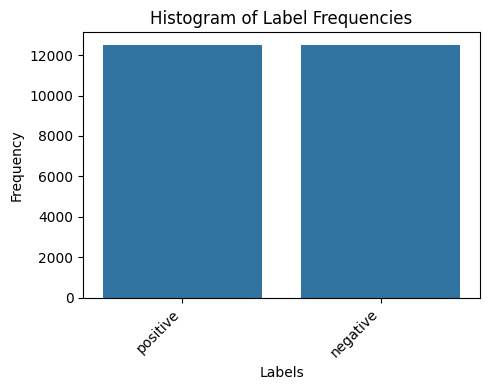

In [6]:
def plot_label_histogram(labels):
    cnt_pos = labels.count(1)
    cnt_neg = labels.count(0)

    # Plot histogram of label frequencies
    plt.figure(figsize=(5, 4))
    sns.barplot(x=['positive','negative'], y=[cnt_pos,cnt_neg])
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Histogram of Label Frequencies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() 
    plt.show()
plot_label_histogram(ds['label'])

## Postive vs Negative reviews

Split the dataset into positive and negative reviews.

In [7]:
#Filter positive reviews
ds_pos = ds.filter(lambda x: x["label"] == 1)

#Filter negative reviews
ds_neg = ds.filter(lambda x: x["label"] == 0)

## Sentence and word length analysis

Both positive and negative reviews have similar distribution of sentence and word lengths. The reviews irrespective of positive or negative 

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

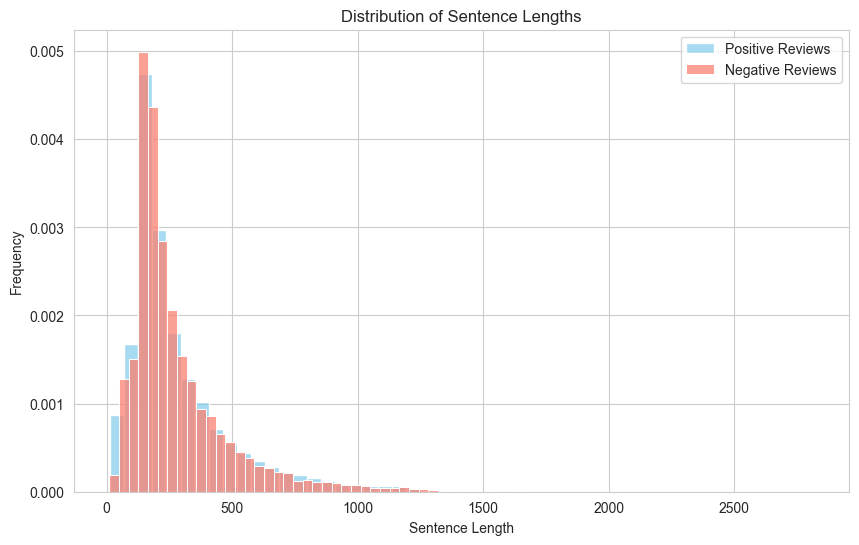

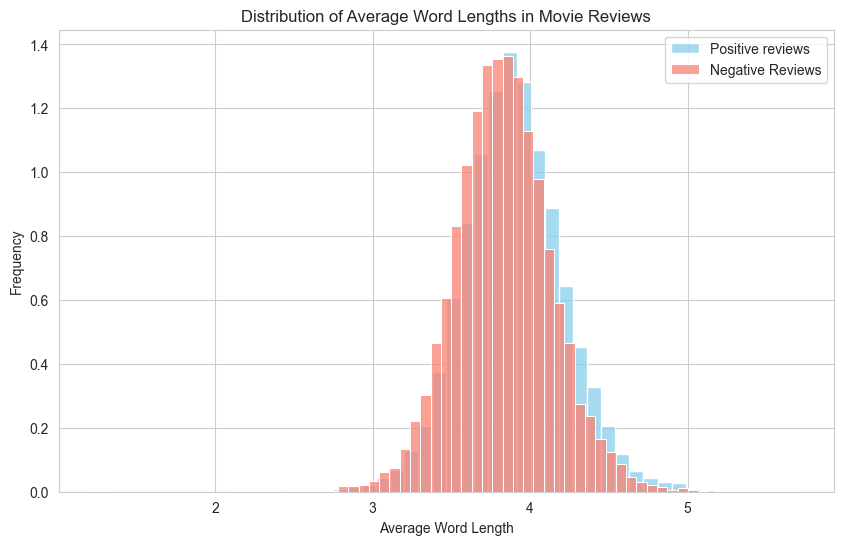

In [8]:
def plot_histogram_sent_len(reviews_pos, reviews_neg):
    # Compute sentence lengths for positive and negative reviews
    rev_len_pos = [len(review) for review in reviews_pos]
    rev_len_neg = [len(review) for review in reviews_neg]
    
    # Set figure size and style
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Plot histogram of sentence lengths for positive reviews
    sns.histplot(rev_len_pos, kde=False, color='skyblue', bins=50, label='Positive Reviews',stat='density')
    
    # Plot histogram of sentence lengths for negative reviews
    sns.histplot(rev_len_neg, kde=False, color='salmon', bins=50, label='Negative Reviews',stat='density')
    
    # Add labels and title
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sentence Lengths')
    plt.legend()
    plt.show()

def plot_histogram_word_len(reviews_pos, reviews_neg):
    # Calculate average word length for each review
    avg_word_lengths_pos = [sum(len(word) for word in review) / len(review) for review in reviews_pos]
    avg_word_lengths_neg = [sum(len(word) for word in review) / len(review) for review in reviews_neg]

    # Plot histogram of average word lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(avg_word_lengths_pos, kde=False, color='skyblue', bins=50,label='Positive reviews',stat='density')
    sns.histplot(avg_word_lengths_neg, kde=False, color='salmon', bins=50, label='Negative Reviews',stat='density')
    plt.xlabel('Average Word Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Average Word Lengths in Movie Reviews')
    plt.legend()
    plt.show()

def tokenize_nltk(review):
    return {'tokens':nltk.word_tokenize(review['text'])}
# Plot histograms of lengths
# pos_reviews = [nltk.word_tokenize(sentence) for sentence in ds_pos['text']]
# neg_reviews = [nltk.word_tokenize(sentence) for sentence in ds_neg['text']]
pos_reviews = ds_pos.map(tokenize_nltk)['tokens']
neg_reviews = ds_neg.map(tokenize_nltk)['tokens']
plot_histogram_sent_len(pos_reviews, neg_reviews)
plot_histogram_word_len(pos_reviews, neg_reviews)


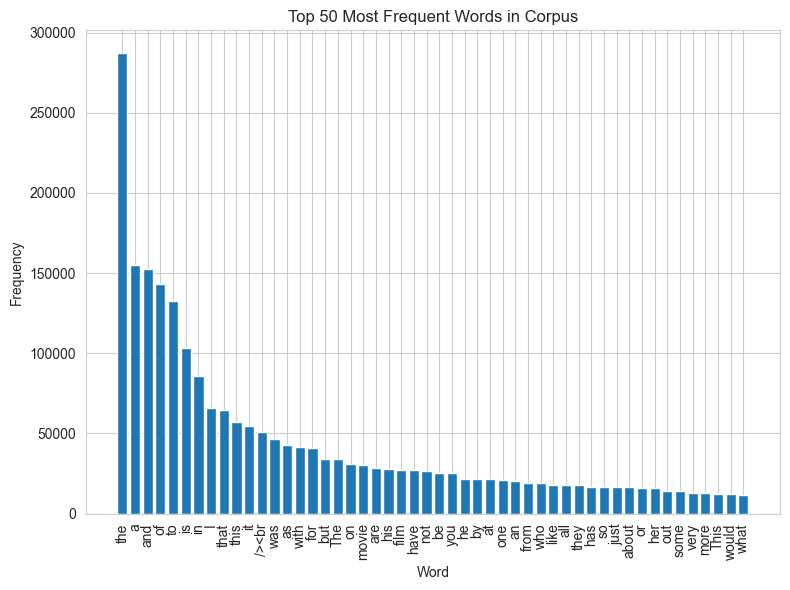

In [10]:
def get_word_count(reviews):
    # Tokenization and word count
    word_counts = Counter()
    for sentence in reviews:
        words = sentence.split()
        word_counts.update(words)

    # Get top 50 words and their frequencies
    top_50_words = word_counts.most_common(50)
    top_50_words, top_50_frequencies = zip(*top_50_words)
    return top_50_words, top_50_frequencies

def plot_word_count(words,freq):
    # Plot top 50 word counts
    plt.figure(figsize=(8, 6))
    plt.bar(words, freq)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title('Top 50 Most Frequent Words in Corpus')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
top_50_words, top_50_frequencies = get_word_count(ds['text'])
plot_word_count(top_50_words, top_50_frequencies)

We see here that the top words are mostly useless stopwords which provide no insight into reviews. The raw corpus usually contains lots of stopwords and other unwanted elements like HTML tags, symbols, pucntuations, etc. So we have to process the data to remove these. 

Lets create for processing of texts.

# Process dataset

In [14]:
def preprocess_text(text,adj:bool=False):
    """Preprocess the corpus.
       Remove stop words, punctuations, html tags
       Optionally return only adjectives from corpus
    Args:
        text (_type_): Review
        adj (bool, optional): Flag to return only adjectives. Defaults to 'False'.

    Returns:
        List: Tokens preprocessed
    """
    # text = review['text']
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Tokenization
    tokens = text.split()

    # Remove punctuation and symbols
    tokens = [token.strip(string.punctuation) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    # Remove 'br' from tokens
    tokens = [token for token in tokens if token != "br"]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words and token.isalnum()]

    if(adj==True):
        # Part-of-speech tagging
        tagged_tokens = nltk.pos_tag(tokens)

        # Extract adjectives
        tokens = [word.lower() for word, pos in tagged_tokens if pos.startswith('JJ')]

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    return {'tokens':tokens}

processed_pos_reviews = ds_pos.map(lambda review: preprocess_text(review['text']))['tokens']
processed_neg_reviews = ds_neg.map(lambda review: preprocess_text(review['text']))['tokens']

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

C:\Users\88mak\AppData\Local\Temp\ipykernel_20276\4162236839.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

# Bi-grams exploration

PLot bi-grams top 10 for both postive and negative reviews. But this time we clean the data by removing html tags, stopwords, symbols, etc.
Bi-grams can help select informative features that capture colloquial patterns, common phrases. It also helps understand the the distinction between positive and negative reviews in this case. In top 10 bi-grams of positive reviews, most are in favour of the movie while in negative reviews most of them are critical of the movie.

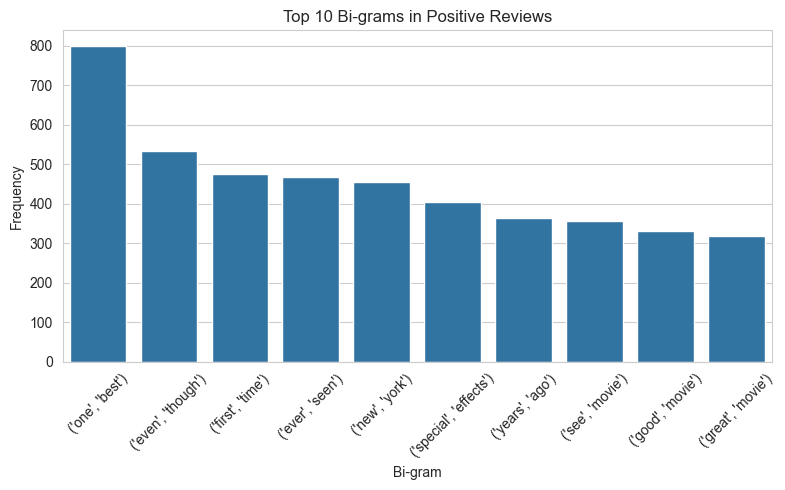

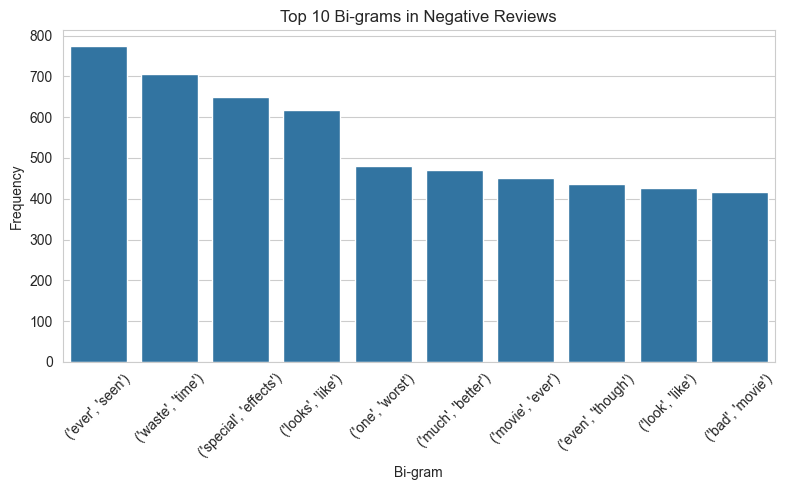

In [15]:
def plot_bi_grams(reviews,title):
    # Create bi-grams from tokenized reviews
    bi_grams = [list(ngrams(review, 2)) for review in reviews]

    # Flatten the list of bi-grams
    flat_bi_grams = [item for sublist in bi_grams for item in sublist]

    # Count the occurrences of each bi-gram
    bi_gram_counts = Counter(flat_bi_grams)

    # Extract bi-grams and their frequencies for top 10
    bi_gram_labels, bi_gram_frequencies = zip(*bi_gram_counts.most_common(10) )

    bi_gram_labels = [str(label) for label in bi_gram_labels]

    # Plot bar plot for top N bi-grams
    plt.figure(figsize=(8, 5))
    sns.barplot(x=bi_gram_labels, y=bi_gram_frequencies)
    plt.xlabel('Bi-gram')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Bi-grams in {title}')
    plt.xticks(rotation=45)  # Rotate x-labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

#PLot bi grams top 5
plot_bi_grams(processed_pos_reviews,"Positive Reviews")
plot_bi_grams(processed_neg_reviews,"Negative Reviews")

# Word frequency analysis - Adjectives
Here we filter on adjectives alone to understand how people are describing the movies in positive and negative reviews.

Lets look at positive reviews first. Here words like great, funny, best, good, etc. dominate. People may use words usually associated with negative reviews as part of their description in a positive review and vice-versa. Hence we see words like bad are also represented in postive reviews. 


C:\Users\88mak\AppData\Local\Temp\ipykernel_20276\4162236839.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


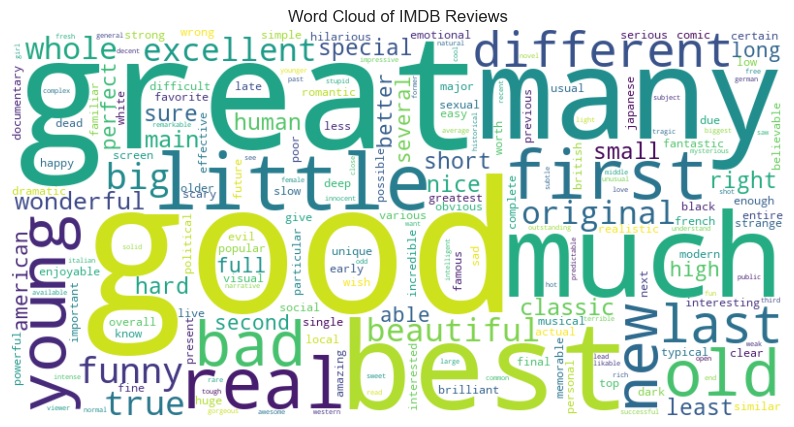

In [17]:

def get_word_frequency(sentences,adj:bool=False):
    """Get frequency of each word in corpus

    Args:
        sentences (str): Review
        adj: Flag to return onle adjectives

    Returns:
        Dict: (WOrd, Freq)
    """
    word_freq = Counter()
    for sentence in sentences:
        filtered_sentence = preprocess_text(sentence,adj)['tokens']
        word_freq.update(filtered_sentence)
    return word_freq

def plot_word_cloud(word_freq:dict):
    """
    Plot the word frequencies as a word cloud
    """
    # Visualization of word distributions
    # Create a word cloud to visualize word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of IMDB Reviews')
    plt.show()
    
# Remove stop words and calculate word frequency - Positive reviews
word_freq_pos = get_word_frequency(ds_pos['text'],True)

# Create a word cloud to visualize word frequencies
plot_word_cloud(word_freq_pos)

Lets look at negative reviews now. Here you see, words like bad, worst, awful , terrible come up a lot. Interesting part is good is used quite often and has a decent representation in the reviews. Once again it could be because of neutral reviews ending up in positive or negative classes.

C:\Users\88mak\AppData\Local\Temp\ipykernel_20276\4162236839.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


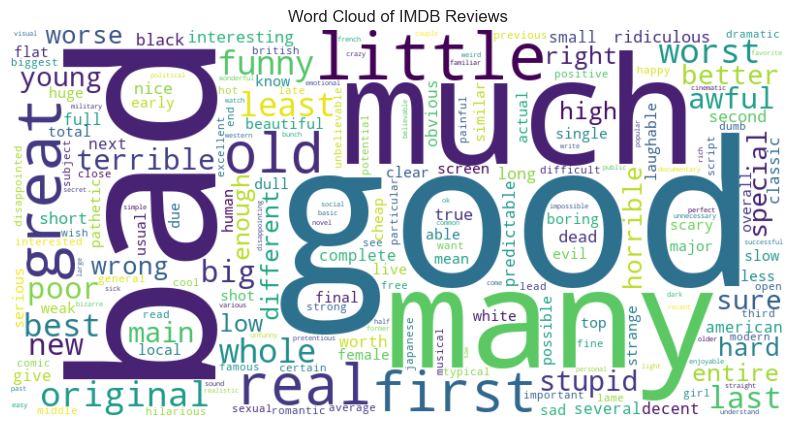

In [18]:
# Remove stop words and calculate word frequency - - Positive reviews
word_freq_neg = get_word_frequency(ds_neg['text'],True)

# Create a word cloud to visualize word frequencies
plot_word_cloud(word_freq_neg)

Need to understand why the word 'good' appears in negative reviews that often.
Would be interesting to understand the context of word good in positive and negative reviews.  
We will use word2vec model to understand the context of the word 'good' in postivie and negative reviews. Word2Vec build static embeddings for each word in vocabulary, taking into consideration a window of context. So based on the corpus and context (short-range), similar words would end up having similar vectors. 
So we use this technique to understand what are the similar words to 'good' in positive and negative reviews.

In [19]:
# Train Word2Vec model - separately for positive and negative reviews
model_neg = Word2Vec(sentences=processed_neg_reviews, vector_size=50, window=3, min_count=1, workers=1)
model_pos = Word2Vec(sentences=processed_pos_reviews, vector_size=50, window=3, min_count=1, workers=1)

Use the word2vec model to get contextual understanding of 'good'

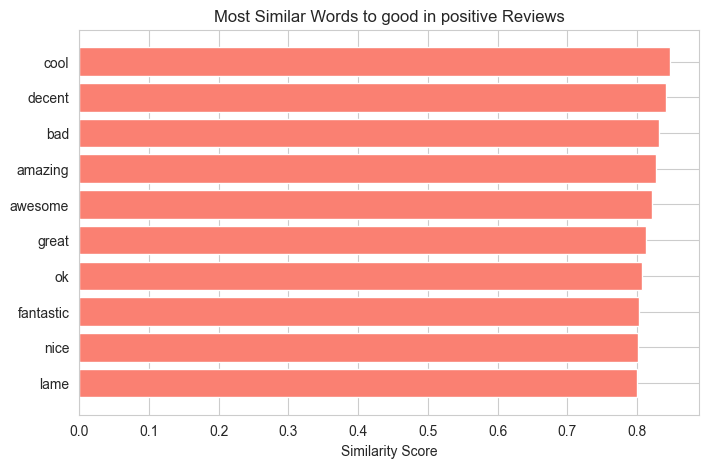

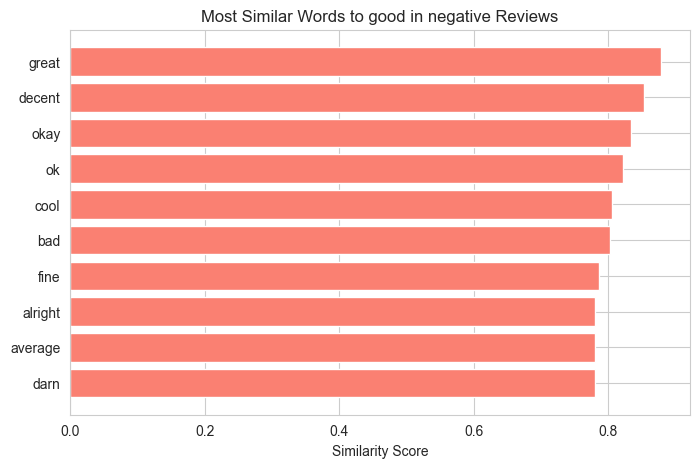

In [20]:
def plot_bar_most_similar_words(similar_words,title):
    # Plotting similar words for negative reviews
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(similar_words)), [score for _, score in similar_words], color='salmon')
    plt.yticks(range(len(similar_words)), [word for word, _ in similar_words])
    plt.xlabel('Similarity Score')
    plt.title(f'Most Similar Words to good in {title} Reviews')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest similarity score at the top
    plt.show()

word = 'good'
similar_words_good_in_pos = model_pos.wv.most_similar(word)
similar_words_good_in_neg = model_neg.wv.most_similar(word)

plot_bar_most_similar_words(similar_words_good_in_pos,'positive')
plot_bar_most_similar_words(similar_words_good_in_neg,'negative')

Here the the word'good' in negative reviews is more associated with words like ok, average, alright, darn, etc. while in positive reviews you see that the 'good' is associated with different words like fantastic, nice, awesome, amazing, etc. So in negative reviews word 'good' is associated lot with neutral emotions. 

We see bad and good appearing in both categories along with great and decent. 

Reasons:

1. The dataset has just two classes - positive and negative. So reviews that are fairly neutral may end up in positive or negative category and eventually become part of the respective word cloud. For example, "not bad" may be neutral and still end up in positive category. 

2. Reviewers may like some aspects of the movie but still leave a negative review overall.

3. We could fine tune the word2vec model futher to make it more accurate if needed.

## Word Association - TSNE

TSNE plot helps us to understand how certain words are associated with other words wrt a specific context. By identifying the closeness of certain words and clusters formed we  can uncover some insights into the thinking of the reviewers. 

In the plot below, a TSNE plot is shown using the embeddings from word2vec model for both positive and negative reviews. For example, you see that oscar is closer to actor, actress and performance in positive reviews but far away in negative reviews. For demo purpose, a random set of words have been plotted. Usually speciifc set of words are selected like top 'n'or from domain experts, to understand their relationships.

This visualization also gives an idea about the quality of dataset. For example you want actors, actress, director to be closer to each other and different parts of film making like screenplay, plot, cinematography, etc to be close together, which is what we see in the visualization. 

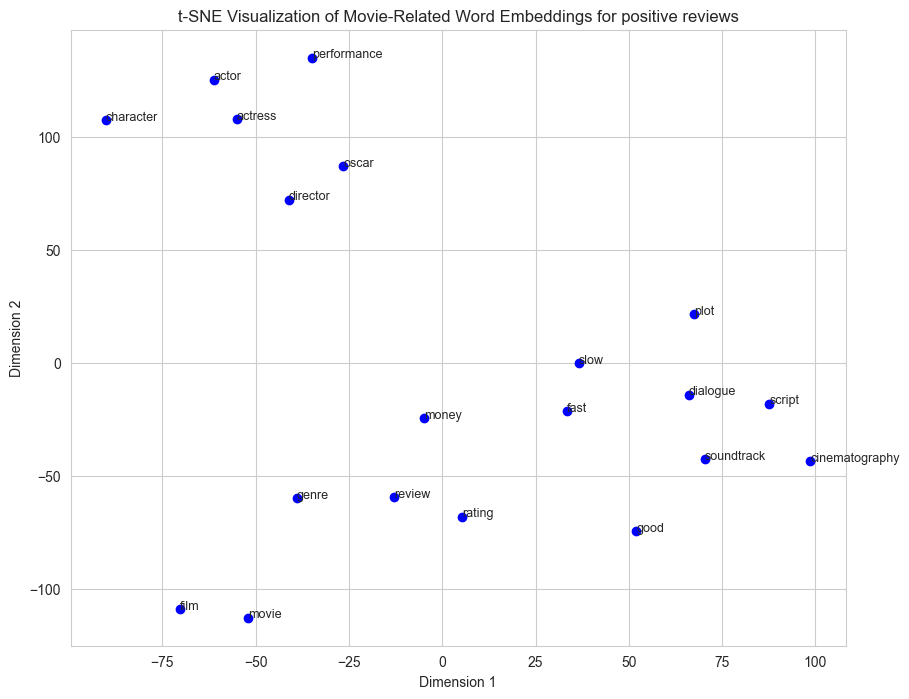

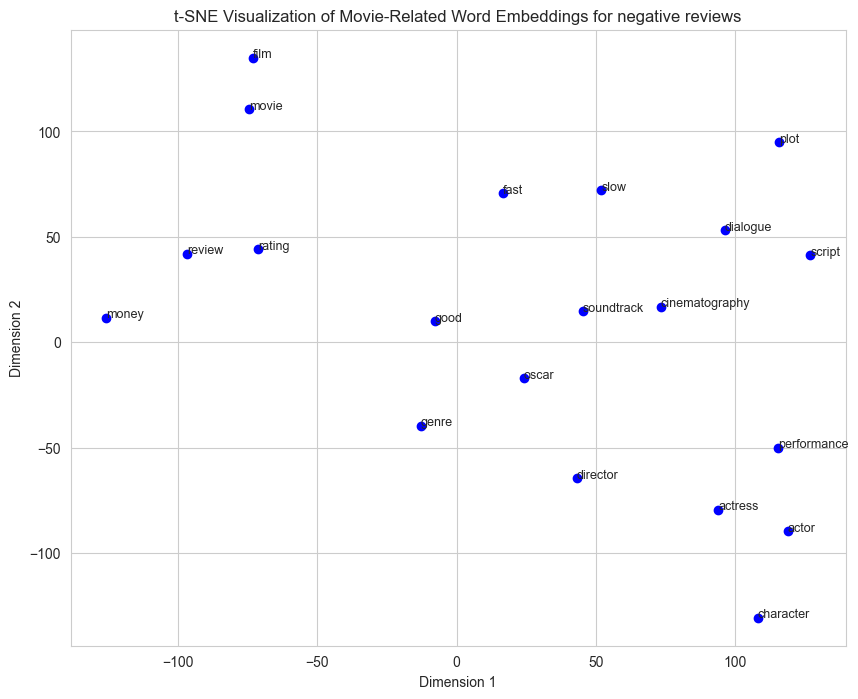

In [21]:
def plot_tsne(words_to_visualize,word2vec_model,title):
    # Get word embeddings for movie-related words
    word_vectors = [word2vec_model.wv[word] for word in words_to_visualize]

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=5,random_state=5)
    word_embeddings_2d = tsne.fit_transform(np.array(word_vectors))

    # Plot t-SNE embeddings
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words_to_visualize):
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], marker='o', color='blue')
        plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=9)
    plt.title(f't-SNE Visualization of Movie-Related Word Embeddings for {title} reviews')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Define movie-related words
words_to_visualize_pos = ["movie", "film", "actor", "actress", "director", "plot", "character", 
                      "cinematography", "soundtrack", "genre", "rating", "review", 
                      "performance", "script", "dialogue","good","fast","oscar","slow","money"]
plot_tsne(words_to_visualize_pos,model_pos,'positive')
plot_tsne(words_to_visualize_pos,model_neg,'negative')